# Project: Review Sentiment Classification

## Acknowledgement:
The datascience module is developed by University of California Berkeley for its Data 8 course.


In [30]:
import datascience
import numpy as np
import graphviz

from datascience import *
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.base import ClassifierMixin
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support

import pandas as pd
import numpy as np

import joblib

# import os
# os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

# Mount Google Drive

We need to first mount the Google Drive in Colab before we can read data from Google Drive.

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
path = "/content/drive/My Drive/IMDBReviewsSentiment.csv"
reviews = Table.read_table(path)
reviews.show(10)

review,sentiment
One of the other reviewers has mentioned that after watc ...,positive
A wonderful little production. The filming t ...,positive
I thought this was a wonderful way to spend time on a to ...,positive
Basically there's a family where a little boy (Jake) thi ...,negative
"Petter Mattei's ""Love in the Time of Money"" is a visuall ...",positive
"Probably my all-time favorite movie, a story of selfless ...",positive
I sure would like to see a resurrection of a up dated Se ...,positive
"This show was an amazing, fresh & innovative idea in the ...",negative
Encouraged by the positive comments about this film on h ...,negative
If you like original gut wrenching laughter you will lik ...,positive


## Sample 1000 positive tweets for constructing your predictive model for movie review sentiment analysis.

In [33]:
pos_reviews = reviews.where("sentiment", are.equal_to('positive')).sample( 1000, with_replacement=False)
pos_reviews.show(10)

review,sentiment
Playing a character from a literary classic can be a bit ...,positive
This film is my favorite comedy of all time and I have s ...,positive
It is a well known fact that when Gene Roddenberry first ...,positive
Some guys think that sniper is not good because of the a ...,positive
"Wendigo is a pretty good psychological thriller, the fil ...",positive
"This little film had long been on my ""keeper"" list. Do p ...",positive
I never thought an old cartoon would bring tears to my e ...,positive
"Michigan, Edgar Allen Poe, a toaster, and a frying pan . ...",positive
This movie was very funny with just a bit of gore. It is ...,positive
at least for me. and rather unexpected -as subject. a mo ...,positive


# Add a Classification Column for Positive Reviews

In [6]:
pos_reviews2 = pos_reviews.with_column("classification", 1)
pos_reviews2.show(5)

review,sentiment,classification
This is a fine drama and a nice change of pace from toda ...,positive,1
"I saw this Documentary at the Cannes Film Festival, in a ...",positive,1
"This movie surprised me. The box is misleading, the tagl ...",positive,1
I just watched this film again and remain dismayed at th ...,positive,1
PUBLIC ENEMIES is a kind of throw-back to those early 19 ...,positive,1


## Sample 1000 negative reviews.

In [7]:
neg_reviews = reviews.where("sentiment", are.equal_to('negative')).sample(1000, with_replacement=False)
neg_reviews.show(10)

review,sentiment
This movie is horrible if you pay attention to it. It's ...,negative
"Many times the description ""full of sound and fury signi ...",negative
The comments already left for this show are way more fun ...,negative
C.H.O.M.P.S. is very much like any number of cheesy late ...,negative
I just couldn't stop laughing!! This movie is incredibly ...,negative
I chuckled a few times during this movie. I laughed out ...,negative
I'm a huge lover of really bad B movies. And I especiall ...,negative
"Right then. This film is totally unfunny, puerile, has g ...",negative
"PLAN B has the appearance of a quickly made, unedited, s ...",negative
Fox is pretty lame. They cancel the wrong shows. It's bi ...,negative


# Add the Classification Column for Negative Reviews

In [8]:
neg_reviews2 = neg_reviews.with_column("classification", 0)
neg_reviews2.show(5)

review,sentiment,classification
This movie is horrible if you pay attention to it. It's ...,negative,0
"Many times the description ""full of sound and fury signi ...",negative,0
The comments already left for this show are way more fun ...,negative,0
C.H.O.M.P.S. is very much like any number of cheesy late ...,negative,0
I just couldn't stop laughing!! This movie is incredibly ...,negative,0


# Add the sampled positive reviews and the sampled negative reviews to form a labelled dataset.

This dataset will be used in this project for creating and evaluating a Decision Tree for sentiment analysis.

In [9]:
data = pos_reviews2.append(neg_reviews2)
data.show(5)

review,sentiment,classification
This is a fine drama and a nice change of pace from toda ...,positive,1
"I saw this Documentary at the Cannes Film Festival, in a ...",positive,1
"This movie surprised me. The box is misleading, the tagl ...",positive,1
I just watched this film again and remain dismayed at th ...,positive,1
PUBLIC ENEMIES is a kind of throw-back to those early 19 ...,positive,1


Extract the review text (under the "review" column") and the classification output (under the "classification" column) for constructing and evaluating decision trees.

Total number of positive reviews and the total number of negative reviews can be printed.

In [10]:
# Use the data for constructing a Decision Tree Classifier for Review Sentiment
data_X = list(data['review'])
data_Y = list(data['classification'])
pos_count = data.where('classification', are.equal_to(1)).num_rows
neg_count = data.where('classification', are.equal_to(0)).num_rows

print('Data size:', len(data_X))
print('Positive Data Size:', pos_count)
print('Negative Data Size:', neg_count)

Data size: 2000
Positive Data Size: 1000
Negative Data Size: 1000


### Stratified KFold Cross Validation
StratifiedKFold is a function in sklearn under the submodule model_selection.
#### Notice: In the beginning of this notebook, we import StratifiedKFold using the following python code:
    from sklearn.model_selection import StratifiedKFold
    
The n_splits parameter of StratifiedKFold indicates how many folds to use.  For example,
n_splits=5 means Stratified 5-fold cross validation.


The following code to specifies the number of folds (i.e., k) in Stratified K-fold Cross Validation.

In [11]:
# Use Stratified Kfold Cross Validation so that
#   each fold contains the same ratio of positive/negative instances
k = 10
skf = StratifiedKFold(n_splits= k , random_state=120, shuffle=True)

The following code to specifies the range of max_depth for finding the best max_depth for a Decision Tree for Sentiment Classification of Movie Reviews.

In [12]:
### Set the range of max_depth for finding the best max_depth for this problem
low_max_depth = 2
high_max_depth = 20
training_performance_table = np.empty([high_max_depth + 1, k, 5])
testing_performance_table = np.empty([high_max_depth + 1, k, 5])

The code performs a k-fold cross-validation process to evaluate the performance of decision trees with varying depths on text data. Here's a step-by-step description of its functionality:

1. **Text Transformation**: Converts review text in each fold into a word frequency matrix, representing the frequency of words in the reviews.

2. **Decision Tree Creation**: Builds a decision tree for sentiment classification using the word frequency matrix of the training reviews and their corresponding sentiment labels.

3. **Evaluation**: Assesses the decision tree's performance using the training data for the current fold.

4. **Cross-Validation Loop**: Repeats the above steps for each fold (`k` times) to ensure robust evaluation across all subsets of the data.

5. **Depth Variation**: Repeats the entire k-fold cross-validation process for each value of `max_depth`, ranging from `low_max_depth` to `high_max_depth`.

The purpose of this approach is to systematically evaluate how the decision tree's performance changes with its depth and ensure consistent evaluation using cross-validation.

In [14]:
for depth in range(low_max_depth, high_max_depth + 1):

    fold = 0

    for train_index, test_index in skf.split(data_X, data_Y):
        print("Fold Number:", fold)


        x_train = list(data.take(train_index)['review'])
    #    print("Training Data:", x_train)
        y_train = list(data.take(train_index)['classification'])
    #    print("Training Data Target Output:", y_train)
        x_test = list(data.take(test_index)['review'])
    #    print("Testing Data:", x_test)
        y_test = list(data.take(test_index)['classification'])

        count_vect = CountVectorizer(token_pattern='(?:([@#]|[0-9]|[a-z]|[A-Z])+)', analyzer='word', min_df=2)
        x_word_vect = count_vect.fit_transform(x_train)

        clf = tree.DecisionTreeClassifier(criterion='entropy', random_state=100, max_depth=depth, min_samples_leaf=2)

        clf.fit(x_word_vect, y_train)

        ### Use the model generated to predict for training data
        predicted_training_y = clf.predict(x_word_vect)

        train_p = metrics.precision_score(y_train, predicted_training_y)
        train_r = metrics.recall_score(y_train, predicted_training_y)
        train_f1= metrics.f1_score(y_train, predicted_training_y)
        training_performance_table[depth, fold, 0] = depth
        training_performance_table[depth, fold, 1] = train_p
        training_performance_table[depth, fold, 2] = train_r
        training_performance_table[depth, fold, 3] = train_f1
        print("Max depth is", depth, "Prediction Performance for Training Data f1:", train_f1)

        ### Use the model generated to predict for testint data
        x_test_word_vect = count_vect.transform(x_test)
        predicted_testing_y = clf.predict(x_test_word_vect)

        test_p  = metrics.precision_score(y_test, predicted_testing_y)
        test_r  = metrics.recall_score(y_test, predicted_testing_y)
        test_f1 = metrics.f1_score(y_test, predicted_testing_y)
        testing_performance_table[depth, fold, 0] = depth
        testing_performance_table[depth, fold, 1] = test_p
        testing_performance_table[depth, fold, 2] = test_r
        testing_performance_table[depth, fold, 3] = test_f1
        print("Prediction Performance for Testing Data f1: ", test_f1)

        fold = fold + 1

Fold Number: 0
Max depth is 2 Prediction Performance for Training Data f1: 0.3840749414519906
Prediction Performance for Testing Data f1:  0.3458646616541353
Fold Number: 1
Max depth is 2 Prediction Performance for Training Data f1: 0.38461538461538464
Prediction Performance for Testing Data f1:  0.34285714285714286
Fold Number: 2
Max depth is 2 Prediction Performance for Training Data f1: 0.27886323268206037
Prediction Performance for Testing Data f1:  0.3971631205673759
Fold Number: 3
Max depth is 2 Prediction Performance for Training Data f1: 0.39039504260263364
Prediction Performance for Testing Data f1:  0.3973509933774834
Fold Number: 4
Max depth is 2 Prediction Performance for Training Data f1: 0.3898695318495779
Prediction Performance for Testing Data f1:  0.4166666666666667
Fold Number: 5
Max depth is 2 Prediction Performance for Training Data f1: 0.3877551020408163
Prediction Performance for Testing Data f1:  0.3142857142857143
Fold Number: 6
Max depth is 2 Prediction Perform

This code calculates performance metrics (average, minimum, and maximum) for the F1 score across k-folds for decision trees trained with different maximum depth settings. Here's a breakdown:

1. **Accessing F1 Scores**:  
   - The `training_performance_table` is a 3D array where:
     - The **first dimension** corresponds to a specific `max_depth` value.
     - The **second dimension** corresponds to a specific fold in the k-fold cross-validation.
     - The **third dimension**, at index `3`, stores the F1 score.  
   - To extract F1 scores for all folds for a specific `max_depth` (e.g., `max_depth = 3`), you access the array at `training_performance_table[3, :, 3]`.

2. **Calculating Metrics**:  
   - The F1 scores for all folds are processed to compute:
     - **Average F1 Score**: Mean of F1 scores across all folds for a specific `max_depth`.
     - **Minimum F1 Score**: The lowest F1 score among all folds.
     - **Maximum F1 Score**: The highest F1 score among all folds.

This process evaluates how well the decision tree performs across different folds and determines the consistency and reliability of its classification performance.

In [15]:
f1_array = training_performance_table[3, 0:k+1:1, 3]
print(f1_array)

[ 0.55197133  0.64308682  0.4272997   0.39039504  0.525       0.55852644
  0.39215686  0.39316239  0.39293937  0.3807267 ]


#### Numpy offers a convenient way to calculate the average, the minimum, and the maximum value of a given array:
    np.average returns the average of a given array
    np.amin returns the minimum value of a given array
    np.amax regturns the maximum value of a given array

In [16]:
np.average(f1_array)

0.46552646544840171

In [17]:
np.amin(training_performance_table[3, 0:k+1:1, 3])

0.38072669826224331

In [18]:
np.amax(training_performance_table[3, 0:k+1:1, 3])

0.64308681672025725

### We want to calculate the average performance across all folds for each max_depth so that we can compare them.

In [19]:
cv_training_f1_summary = np.empty([high_max_depth + 1, 3])
cv_testing_f1_summary  = np.empty([high_max_depth + 1, 3])
first_fold = 0
last_fold  = 5 + 1
for depth in range(low_max_depth, high_max_depth + 1):
    train_f1_array = training_performance_table[depth, first_fold:last_fold:1, 3]
    cv_training_f1_summary[depth, 0] = np.average(train_f1_array)
    cv_training_f1_summary[depth, 1] = np.amin(train_f1_array)
    cv_training_f1_summary[depth, 2] = np.amax(train_f1_array)
    test_f1_array = testing_performance_table[depth, first_fold:last_fold:1, 3]
    cv_testing_f1_summary[depth, 0] = np.average(test_f1_array)
    cv_testing_f1_summary[depth, 1] = np.amin(test_f1_array)
    cv_testing_f1_summary[depth, 2] = np.amax(test_f1_array)

### We want to plot the average of f1 scores (across all k folds) for each max_depth, and compare the average of f1 scores for training data and testing data

In [20]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import *

In [21]:
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [22]:
depth = np.linspace(low_max_depth, high_max_depth, high_max_depth - low_max_depth + 1)
print(depth)

[  2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.  16.
  17.  18.  19.  20.]


In [23]:
avg_f1_training = cv_training_f1_summary[low_max_depth:high_max_depth+1, 0]
min_f1_training = cv_training_f1_summary[low_max_depth:high_max_depth+1, 1]
avg_f1_testing = cv_testing_f1_summary[low_max_depth:high_max_depth+1, 0]
min_f1_testing = cv_testing_f1_summary[low_max_depth:high_max_depth+1, 1]

The code plots the average F1 score (across k folds) for training and testing data at various `max_depth` values. It calculates average F1 scores for each `max_depth`, then visualizes them using a line graph with `max_depth` on the x-axis and average F1 scores on the y-axis. The plot includes labels, legends, and gridlines to compare training and testing performance, highlighting trends like overfitting or underfitting.

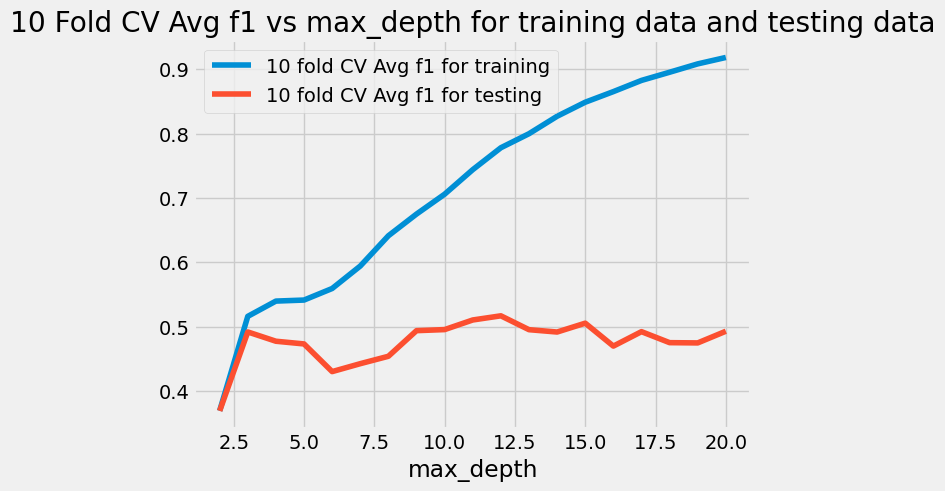

In [24]:
training_avg_f1_label = str(k) + ' fold CV Avg f1 for training'
testing_avg_f1_label  = str(k) + ' fold CV Avg f1 for testing'

plt.plot(depth, avg_f1_training, label=training_avg_f1_label)
plt.plot(depth, avg_f1_testing, label=testing_avg_f1_label)
plt.xlabel('max_depth')
plot_title = str(k) + " Fold CV Avg f1 vs max_depth for training data and testing data"
plt.title(plot_title)
plt.legend()
plt.show()

This code plots the average and minimum F1 scores across k-folds for training and testing data against `max_depth`. It dynamically labels each line, adds a title reflecting the k-fold setup, and includes a legend. The plot helps compare training and testing performance trends at different `max_depth` values.

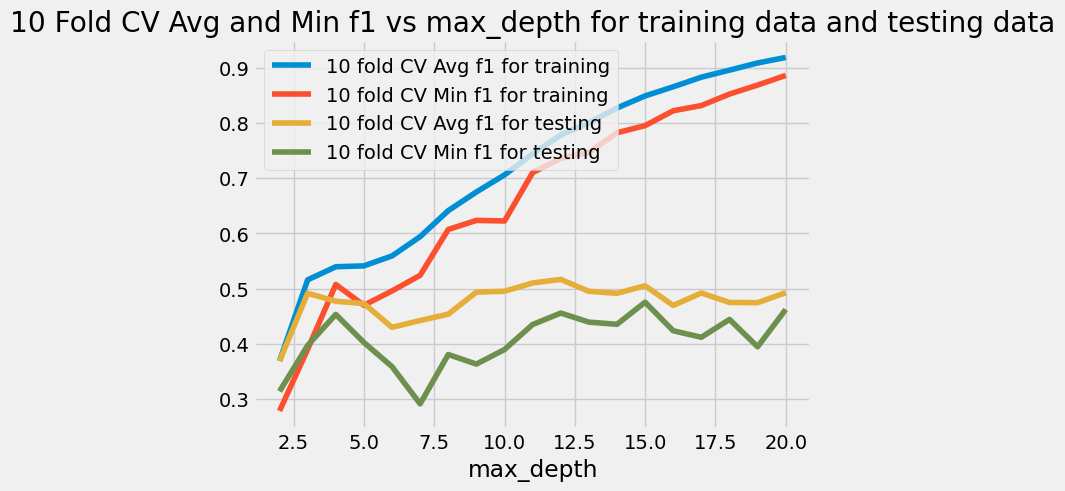

In [25]:
training_min_f1_label = str(k) + ' fold CV Min f1 for training'
testing_min_f1_label  = str(k) + ' fold CV Min f1 for testing'

plt.plot(depth, avg_f1_training, label=training_avg_f1_label)
plt.plot(depth, min_f1_training, label=training_min_f1_label)
plt.plot(depth, avg_f1_testing,  label=testing_avg_f1_label)
plt.plot(depth, min_f1_testing,  label=testing_min_f1_label)
plt.xlabel('max_depth')
plot_title = str(k) + ' Fold CV Avg and Min f1 vs max_depth for training data and testing data'
plt.title(plot_title)
plt.legend()
plt.show()

This exercise involves selecting the optimal `max_depth` based on an analysis of prediction performance and the risk of overfitting. The explanation highlights that at a depth of 4, the model achieves a balance: it minimizes the risk of overfitting while being sufficiently deep to avoid underfitting. Beyond a depth of 6, overfitting becomes evident as performance declines, reinforcing the choice of 4 as the best depth.